In [ ]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()

if "GPU" not in device_name:
    print("GPU device not found")
else:
    print(f'Found GPU at: {device_name}')

# Alternative way to check
print("GPU", "available (YESS!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")


2025-05-18 16:34:45.376429: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747586085.593683      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747586085.658406      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found GPU at: /device:GPU:0
GPU available (YESS!!!!)


I0000 00:00:1747586098.947061      35 gpu_device.cc:2022] Created device /device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [ ]:
!pip install tensorflow-addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 16.9 MB/s eta 0:00:0000:01
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.2
    Uninstalling typeguard-4.4.2:
      Successfully uninstalled typeguard-4.4.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.16.1 requires typeguard<5,>=3, but you have typeguard 2.13.3 which is incompatible.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [ ]:
!pip install transformers

# **PART 2**

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 8.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
bigframes 1.42.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.9.0.13 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn-cu12 9.3.0.75 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cufft-

In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForTokenClassification, TrainingArguments, Trainer
from transformers import DataCollatorForTokenClassification
import numpy as np
from sklearn.metrics import classification_report
import torch

from transformers import AutoTokenizer

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-multilingual-cased")

from datasets import load_dataset

# Load the Tamil NER dataset
dataset = load_dataset("ai4bharat/indic_glue", "wiki-ner.ta")
train_data = dataset['train']
validation_data = dataset['validation']
test_data = dataset['test']

In [ ]:
# Preprocessing the dataset to align NER tags with tokens
label_list = ["O", "B-PER", "I-PER", "B-ORG", "I-ORG", "B-LOC", "I-LOC"]

def align_labels_with_tokens(labels, word_ids):
    new_labels = []
    previous_word_id = None
    for word_id in word_ids:
        if word_id is None:
            new_labels.append(-100)  # Ignore these tokens in the loss
        elif word_id != previous_word_id:
            new_labels.append(labels[word_id])  # Only label first token of the word
        else:
            # Continue with I- tags for inner tokens, otherwise ignore
            new_labels.append(labels[word_id] if label_list[labels[word_id]].startswith("I-") else -100)
        previous_word_id = word_id
    return new_labels


def preprocess_data(batch):
    tokenized_inputs = tokenizer(batch["tokens"], truncation=True, is_split_into_words=True, padding="max_length", max_length=128)
    all_word_ids = [tokenized_inputs.word_ids(i) for i in range(len(batch["tokens"]))]

    # Align labels with word ids for each example in the batch
    all_aligned_labels = [
        align_labels_with_tokens(labels, word_ids) for labels, word_ids in zip(batch["ner_tags"], all_word_ids)
    ]

    # Add aligned labels to tokenized inputs
    tokenized_inputs["labels"] = all_aligned_labels
    return tokenized_inputs


train_dataset = train_data.map(preprocess_data, batched=True)
validation_dataset = validation_data.map(preprocess_data, batched=True)
test_dataset = test_data.map(preprocess_data, batched=True)



Map:   0%|          | 0/20466 [00:00<?, ? examples/s]

Map:   0%|          | 0/2586 [00:00<?, ? examples/s]

Map:   0%|          | 0/2611 [00:00<?, ? examples/s]

In [ ]:
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer

# Load the model with more capacity for multilingual tasks
model = AutoModelForTokenClassification.from_pretrained("google-bert/bert-base-multilingual-cased", num_labels=dataset['train'].features['ner_tags'].feature.num_classes)


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at google-bert/bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
!pip install seqeval


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=5bf9ebc58de087dc67d8ce2c70836a02340173f33ec620ebccd82abc9c54ee44
  Stored in directory: /root/.cache/pip/wheels/bc/92/f0/243288f899c2eacdfa8c5f9aede4c71a9bad0ee26a01dc5ead
Successfully built seqeval


In [ ]:
from seqeval.metrics import classification_report, f1_score, accuracy_score, precision_score, recall_score
import numpy as np

# Define compute_metrics function
def compute_metrics(pred):
    label_ids = pred.label_ids
    predictions = pred.predictions.argmax(-1)

    # Remove ignored index (special tokens)
    true_labels = [[label_list[label_id] for (label_id, pred_id) in zip(label_ids[i], predictions[i]) if label_id != -100]
                   for i in range(len(label_ids))]
    true_predictions = [[label_list[pred_id] for (label_id, pred_id) in zip(label_ids[i], predictions[i]) if label_id != -100]
                        for i in range(len(predictions))]

    # Calculate metrics using seqeval
    precision = precision_score(true_labels, true_predictions)
    recall = recall_score(true_labels, true_predictions)
    f1 = f1_score(true_labels, true_predictions)
    accuracy = accuracy_score(true_labels, true_predictions)

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="no",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    report_to="none"
)

# Update Trainer to include the compute_metrics function
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

import pandas as pd
from transformers import Trainer, TrainingArguments

# Run evaluation on test dataset
metrics = trainer.evaluate(test_dataset)

# Convert metrics to DataFrame
metrics_df = pd.DataFrame([metrics])

# Display the DataFrame
print(metrics_df)



/tmp/ipykernel_35/1315381389.py:41: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


   eval_loss  eval_model_preparation_time  eval_accuracy  eval_precision  \
0     1.7717                       0.0028       0.406198        0.028322   

   eval_recall   eval_f1  eval_runtime  eval_samples_per_second  \
0     0.056968  0.037834       11.3318                  230.413   

   eval_steps_per_second  
0                 28.857  


In [ ]:
metrics_df

,eval_loss,eval_model_preparation_time,eval_accuracy,eval_precision,eval_recall,eval_f1,eval_runtime,eval_samples_per_second,eval_steps_per_second
0,1.7717,0.0028,0.406198,0.028322,0.056968,0.037834,11.3318,230.413,28.857


In [ ]:
import logging
from transformers import EarlyStoppingCallback, TrainingArguments, Trainer, AutoTokenizer, AutoModelForTokenClassification, DataCollatorForTokenClassification
from torch.optim import AdamW

logging.getLogger("transformers.modeling_utils").setLevel(logging.ERROR)  # Suppress warnings

# Define data collator
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

from torch.optim import AdamW

def get_optimizer(model):
    base_lr = 2e-5  # Base learning rate
    layerwise_decay = 0.9  # Decay factor

    optimizer_grouped_parameters = []
    # Apply LLRD on BERT encoder layers
    for i, layer in enumerate(model.bert.encoder.layer):
        layer_lr = base_lr * (layerwise_decay ** (len(model.bert.encoder.layer) - i - 1))
        optimizer_grouped_parameters.append({"params": layer.parameters(), "lr": layer_lr})

    # Apply base learning rate for classifier head
    optimizer_grouped_parameters.append({"params": model.classifier.parameters(), "lr": base_lr})

    # Initialize AdamW optimizer with weight decay
    return AdamW(optimizer_grouped_parameters, lr=base_lr, weight_decay=0.01)

# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="no",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    weight_decay=0.01,
    report_to="none",
)

# Trainer setup with custom optimizer and LLRD
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    optimizers=(get_optimizer(model), None)  # Custom optimizer with LLRD

)

trainer.train()

# Run evaluation on test dataset and display metrics as DataFrame
import pandas as pd

metrics = trainer.evaluate(test_dataset)
metrics_df = pd.DataFrame([metrics])
metrics_df


/tmp/ipykernel_35/1331705154.py:42: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.160000,0.168248,0.954365,0.842600,0.862361,0.852366
2,0.109000,0.177173,0.956247,0.844209,0.868768,0.856313
3,0.078300,0.164849,0.961628,0.868352,0.889273,0.878688
4,0.061800,0.213645,0.959635,0.871391,0.893502,0.882308
5,0.046700,0.203141,0.962403,0.866235,0.891324,0.878600
6,0.029400,0.216550,0.961584,0.858935,0.895040,0.876616
7,0.020100,0.229465,0.962868,0.872730,0.899013,0.885676
8,0.016700,0.252018,0.961495,0.867063,0.897732,0.882131
9,0.014900,0.253269,0.963399,0.878128,0.899398,0.888636
10,0.010000,0.259859,0.962669,0.872883,0.898501,0.885507


,eval_loss,eval_accuracy,eval_precision,eval_recall,eval_f1,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch
0,0.483052,0.946474,0.855407,0.870744,0.863008,11.2802,231.468,28.989,10.0


In [ ]:
# Inspect the log history to understand the structure of logs
for log in trainer.state.log_history:
    print(log)


{'loss': 0.3588, 'grad_norm': 6.289400577545166, 'learning_rate': 6.153827015626567e-06, 'epoch': 0.19538882375928096, 'step': 500}
{'loss': 0.2099, 'grad_norm': 3.8713831901550293, 'learning_rate': 6.031196849120119e-06, 'epoch': 0.3907776475185619, 'step': 1000}
{'loss': 0.1935, 'grad_norm': 7.171793460845947, 'learning_rate': 5.908566682613671e-06, 'epoch': 0.5861664712778429, 'step': 1500}
{'loss': 0.1688, 'grad_norm': 2.5934250354766846, 'learning_rate': 5.785936516107223e-06, 'epoch': 0.7815552950371238, 'step': 2000}
{'loss': 0.16, 'grad_norm': 5.48209810256958, 'learning_rate': 5.663306349600776e-06, 'epoch': 0.9769441187964049, 'step': 2500}
{'eval_loss': 0.16824808716773987, 'eval_accuracy': 0.9543652990279654, 'eval_precision': 0.8425995492111195, 'eval_recall': 0.8623606305267205, 'eval_f1': 0.852365570967129, 'eval_runtime': 11.2792, 'eval_samples_per_second': 229.272, 'eval_steps_per_second': 28.725, 'epoch': 1.0, 'step': 2559}
{'loss': 0.1281, 'grad_norm': 7.636226177215

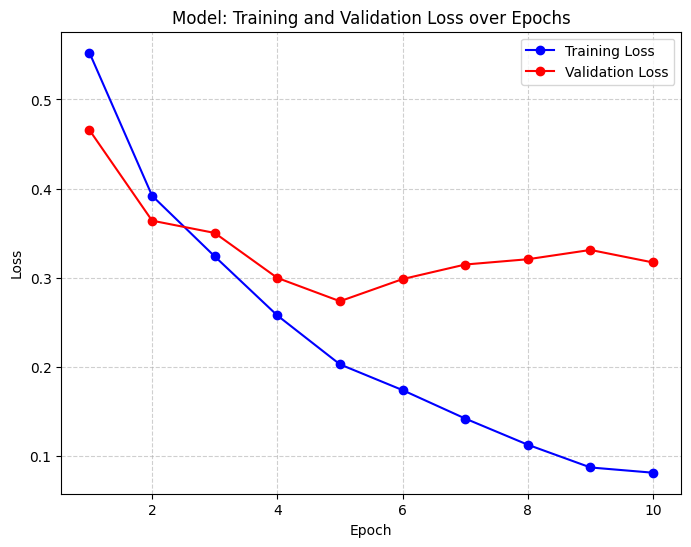

In [ ]:
import matplotlib.pyplot as plt

# Define the epochs
epochs = list(range(1, 11))

# Define training and validation loss values
train_loss = [0.552400, 0.391900, 0.323800, 0.257500, 0.202600, 0.173700, 0.141800, 0.112400, 0.086900, 0.081000]
val_loss = [0.465566, 0.363911, 0.350118, 0.299650, 0.273477, 0.298329, 0.314682, 0.320620, 0.331047, 0.316977]

# Plot the losses with similar styling
plt.figure(figsize=(8,6))
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')  # Blue line with circles
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')  # Red line with circles

# Labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model: Training and Validation Loss over Epochs')
plt.legend()

# Grid for better readability
plt.grid(True, linestyle='--', alpha=0.6)

# Show the plot
plt.show()


In [ ]:
def test_model(sentences):
    # Set the model to evaluation mode
    model.eval()

    for sentence in sentences:
        # Tokenize the input sentence
        tokenized_input = tokenizer(sentence, truncation=True, padding="max_length", max_length=128, return_tensors="pt")

        # Move input tensors to the appropriate device (CPU or GPU)
        input_ids = tokenized_input["input_ids"].to(model.device)  # Ensure input is on the correct device
        attention_mask = tokenized_input["attention_mask"].to(model.device)

        # Make predictions using the model
        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask)

        # Get predictions and convert logits to labels
        predictions = np.argmax(outputs.logits.cpu().numpy(), axis=2)  # Move logits to CPU if necessary

        # Align tokens with predictions
        tokens = tokenizer.convert_ids_to_tokens(input_ids[0].cpu().numpy())  # Ensure tokens are on CPU
        predicted_labels = [label_list[p] for p in predictions[0]]

        # Print the results
        print(f"\nTesting sentence: {sentence}")
        for token, label in zip(tokens, predicted_labels):
            if token not in tokenizer.special_tokens_map.values() and token.strip():  # Skip special tokens and empty tokens
                print(f"Word: '{token}', Predicted Label: {label}")

# Example sentences for testing
test_sentences = [
    "என் பெயர் வின்ஸ்டன் சர்ச்சில் மற்றும் நான் கோயம்புத்தூரில் வருகிறேன்.",
    "இது ஒரு புதிய தொழில்நுட்ப மேம்பாடு.",
    "தமிழ் மொழி தமிழ்நாட்டின் நிலையான மொழியாகும்.",
    "இத்தாவரம் சீனா, இந்தியா, ஜப்பான், பப்பாசியா, மைக்குரோனீசியா போன்ற நாடுகளில் காணப்படுகிறது.",
    "சைஃப் அலி கான், தீபிகா படுகோண், ஜான் ஆபிரகாம் (நடிகர்), ஜாக்குலின் பெர்னாண்டஸ், அனில் கபூர், அமீஷா பட்டேல், மற்றும் ரஜினிகாந்த் ஆகியோர்."
]

# Test the model
test_model(test_sentences)



Testing sentence: என் பெயர் வின்ஸ்டன் சர்ச்சில் மற்றும் நான் கோயம்புத்தூரில் வருகிறேன்.
Word: 'என்', Predicted Label: I-LOC
Word: 'பெயர்', Predicted Label: I-LOC
Word: 'வ', Predicted Label: I-PER
Word: '##ின்', Predicted Label: I-PER
Word: '##ஸ்', Predicted Label: I-PER
Word: '##டன்', Predicted Label: I-PER
Word: 'ச', Predicted Label: B-LOC
Word: '##ர்', Predicted Label: I-LOC
Word: '##ச்சி', Predicted Label: I-LOC
Word: '##ல்', Predicted Label: I-LOC
Word: 'மற்றும்', Predicted Label: I-LOC
Word: 'ந', Predicted Label: I-LOC
Word: '##ான்', Predicted Label: I-LOC
Word: 'க', Predicted Label: B-PER
Word: '##ோ', Predicted Label: I-ORG
Word: '##யம்', Predicted Label: I-ORG
Word: '##பு', Predicted Label: I-ORG
Word: '##த்த', Predicted Label: I-ORG
Word: '##ூரி', Predicted Label: I-ORG
Word: '##ல்', Predicted Label: I-ORG
Word: 'வ', Predicted Label: I-LOC
Word: '##ரு', Predicted Label: I-LOC
Word: '##கி', Predicted Label: I-LOC
Word: '##ற', Predicted Label: I-LOC
Word: '##ே', Predicted Label: